In [1]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import tree
from jax import random
from jax import make_jaxpr
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple, NamedTuple
import functools

### The Problem of State

In [2]:
# NumPy version

class Counter:
    """A simple counter."""

    def __init__(self):
        self.n = 0

    def count(self) -> int:
        self.n += 1
        return self.n
    
    def reset(self):
        self.n = 0

counter = Counter()

for _ in range(3):
    print(counter.count())

1
2
3


In [3]:
counter.reset()
fast_count = jit(counter.count)

for _ in range(3):
    print(fast_count())

1
1
1


In [4]:
counter.reset()
print(make_jaxpr(counter.count)())

{ lambda ; . let  in (1,) }


In [5]:
# Solution

CounterState = int # our counter state is implemented as a simple integer

class CounterV2:
    """modified Jax suitale counter"""

    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # actually, the first output argument can be any function we want
        # the first argument is for function on self, and the second argument is a Counter
        return n+1, n+1
    
    def reset(self) -> CounterState:
        return 0
    
counter = CounterV2()
state = counter.reset()

for _ in range(3):
    value, state = counter.count(state)
    print(value)

1
2
3


In [6]:
state = counter.reset()
fast_count = jit(counter.count)

for _ in range(3):
    value, state = fast_count(state)
    print(value)

1
2
3


In summary, we use the following rule to convert a stateful class into stateless:

```python
class StatefullClass:

    state: State
    
    def stateful_method(*args, **kwargs) -> Output:

class StatelessClass:

    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

### Enter PyTree

#### PyTree basics

In [7]:
pytree_example = [
    [1, 'a', object],
    (1, (1, 3), ()),
    [1, {'k1':2, 'k2':(3, 4)}, 5],
    {'a':2, 'b':(2, 3)},
    jnp.array([1, 2, 3]),
]

for pytree in pytree_example:
    leaves = tree.leaves(pytree)
    print(f"{repr(pytree):45} has {len(leaves)} leaves:{leaves}")

[1, 'a', <class 'object'>]                    has 3 leaves:[1, 'a', <class 'object'>]
(1, (1, 3), ())                               has 3 leaves:[1, 1, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves:[1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves:[2, 2, 3]
Array([1, 2, 3], dtype=int32)                 has 1 leaves:[Array([1, 2, 3], dtype=int32)]


In [8]:
# How do we manipulate PyTrees？

list_of_lists = [
    {'a':3},
    [1, 2, 3],
    (1, 2),
    [1, 2, 3, 4]
]

print(tree.map(lambda x: x*2, list_of_lists))

[{'a': 6}, [2, 4, 6], (2, 4), [2, 4, 6, 8]]


In [9]:
# Two PyTree should have the same structure

another_list_of_lists = list_of_lists
print(tree.map(lambda x, y: x + y, list_of_lists, another_list_of_lists))

[{'a': 6}, [2, 4, 6], (2, 4), [2, 4, 6, 8]]


#### Less contrived example: training a toy MLP (multi-layer perceptron) model

In [10]:
def init_mlp_params(layer_widths):

    params = []

    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2 / n_in),
                 biases = np.ones(shape=(n_out,)))
        )
    
    return params

params = init_mlp_params([1, 128, 128, 1])
print("layer_widths[:-1]: ", [1, 128, 128, 1][:-1])
print("layer_widths[1:]: ", [1, 128, 128, 1][1:])

jax.tree.map(lambda x: x.shape, params)

layer_widths[:-1]:  [1, 128, 128]
layer_widths[1:]:  [128, 128, 1]


[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [11]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])
    
    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2) # MSE loss

lr = 0.0001

@jit
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params
    # grad is one of the many JAX functions that has built-in support for pytrees!
    grads = grad(loss_fn)(params, x, y)
    
    # SGD update
    return tree.map(lambda p, g: p - lr * g, params, grads)

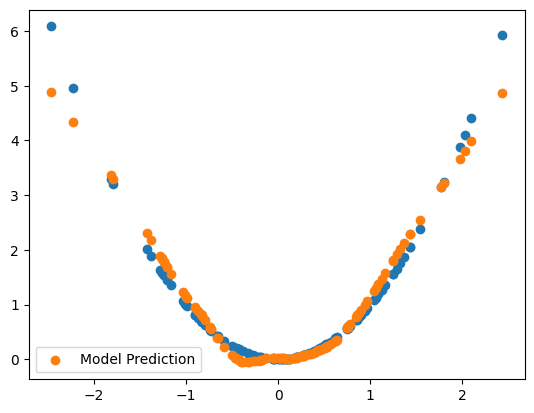

In [12]:
xs = np.random.normal(size=(128,1))
ys = xs**2
# ys = xs**3 + xs
# ys = np.sin(xs)

num_epochs = 5000
for _ in range(num_epochs):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs,  forward(params, xs), label='Model Prediction')
plt.legend(); plt.show()

#### Custom PyTrees

In [13]:
class MyContainer:
    def __init__(self, name: str, a: int, b: int, c:int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c        

In [14]:
example_pytree = [MyContainer('Alice', 1, 2, 3), MyContainer('Bob', 4, 5, 6)] # 8 leaves

leaves = tree.leaves(example_pytree)
print(f'{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n{leaves})') # however, only 2 leaves

[<__main__.MyContainer object at 0x000001DB3457DBB0>, <__main__.MyContainer object at 0x000001DB34566300>]
 has 2 leaves:
[<__main__.MyContainer object at 0x000001DB3457DBB0>, <__main__.MyContainer object at 0x000001DB34566300>])


In [15]:
# Lets get this work!!!

def flatten_MyContainer(container):
    """returns on iterable over container contents, and aux date"""
    flat_contents = [container.a, container.b, container.c]
    
    # we dont want the name to appear as a child, so it is auxilarry data.
    # auxularry dara is usually a discription of the structureof a node, but not the data itself
    aux_data = container.name
    
    return flat_contents, aux_data

def unflattem_MyContainer(aux_data, flat_contents):
    """converts aux data and flat contents into a MyContainer"""
    return MyContainer(aux_data, *flat_contents)

jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflattem_MyContainer)

In [16]:
leaves = jax.tree.leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n{leaves}")

[<__main__.MyContainer object at 0x000001DB3457DBB0>, <__main__.MyContainer object at 0x000001DB34566300>]
 has 6 leaves:
[1, 2, 3, 4, 5, 6]


In [17]:
result = jax.tree.map(lambda x: x + 1, example_pytree)
print(jax.tree.leaves(result))

[2, 3, 4, 5, 6, 7]


In [18]:
# Finally, a common gotcha working with PyTrees: mistaking nodes for leaves/children

zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]
print(zeros_tree)

# Try to make anothr three with ones instead of zeros
shapes = jax.tree.map(lambda x: x.shape, zeros_tree)
print(shapes)

ones_tree = jax.tree.map(jnp.ones, shapes)
print("Undesired outcome \n", ones_tree) # However, (2, 3) is also a PyTree! so jnp.one will apply on 2, 3 saperately!!

# Solution
shapes = jax.tree.map(lambda x: jnp.array(x.shape), zeros_tree) # now, jnp.array((2, 3)) is a leave!

ones_tree = jax.tree.map(jnp.ones, shapes)
print("Desiredd outcome \n", ones_tree)

[Array([[0., 0., 0.],
       [0., 0., 0.]], dtype=float32), Array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)]
[(2, 3), (3, 4)]
Undesired outcome 
 [(Array([1., 1.], dtype=float32), Array([1., 1., 1.], dtype=float32)), (Array([1., 1., 1.], dtype=float32), Array([1., 1., 1., 1.], dtype=float32))]
Desiredd outcome 
 [Array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32), Array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]], dtype=float32)]


### Parallelism in JAX
parallelism in JAX is handled by another fundamental transform function: pmap

#### pmap basics
This should be done on TPU

In [21]:
jax.devices()


[CpuDevice(id=0)]

#### Useful functions
value_and_grad and has_aux

In [19]:
def sum_squared_error(x, y):
    return sum((x - y)**2)

x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1
print(x)

# An efficient way to return both grads and loss value
jax.value_and_grad(sum_squared_error)(x, y)

[0. 1. 2. 3.]


(Array(0.03999997, dtype=float32),
 Array([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32))

In [20]:
# And sometimes the loss function needs to return intermediate results

def sum_squared_error_with_aux(x, y):
    return sum((x - y)**2), x - y

loss, aux = jax.grad(sum_squared_error_with_aux, has_aux=True)(x, y)
print("loss: ", loss)
print("aux: ", aux)
jax.grad(sum_squared_error_with_aux, has_aux=True)(x, y) # with has_aux=False, grad will onlywork for scalar-output functions

loss:  [-0.2        -0.20000005 -0.19999981 -0.19999981]
aux:  [-0.1        -0.10000002 -0.0999999  -0.0999999 ]


(Array([-0.2       , -0.20000005, -0.19999981, -0.19999981], dtype=float32),
 Array([-0.1       , -0.10000002, -0.0999999 , -0.0999999 ], dtype=float32))

#### Training a very simple model in parallel
Codes on Colab